In [1]:
#Run this block more than once
!pip install mediapipe
import mediapipe as mp

In [2]:
import requests
# Download 3 random faces
image_paths = ["/content/frontal1.jpg", "/content/frontal2.jpg", "/content/frontal3.jpg"]
for path in image_paths:
    resp = requests.get("https://thispersondoesnotexist.com/")
    if resp.status_code == 200:
        with open(path, "wb") as f:
            f.write(resp.content)

In [3]:
import cv2, numpy as np, mediapipe as mp
from PIL import Image
from io import BytesIO
from IPython.display import Image as IPyImage

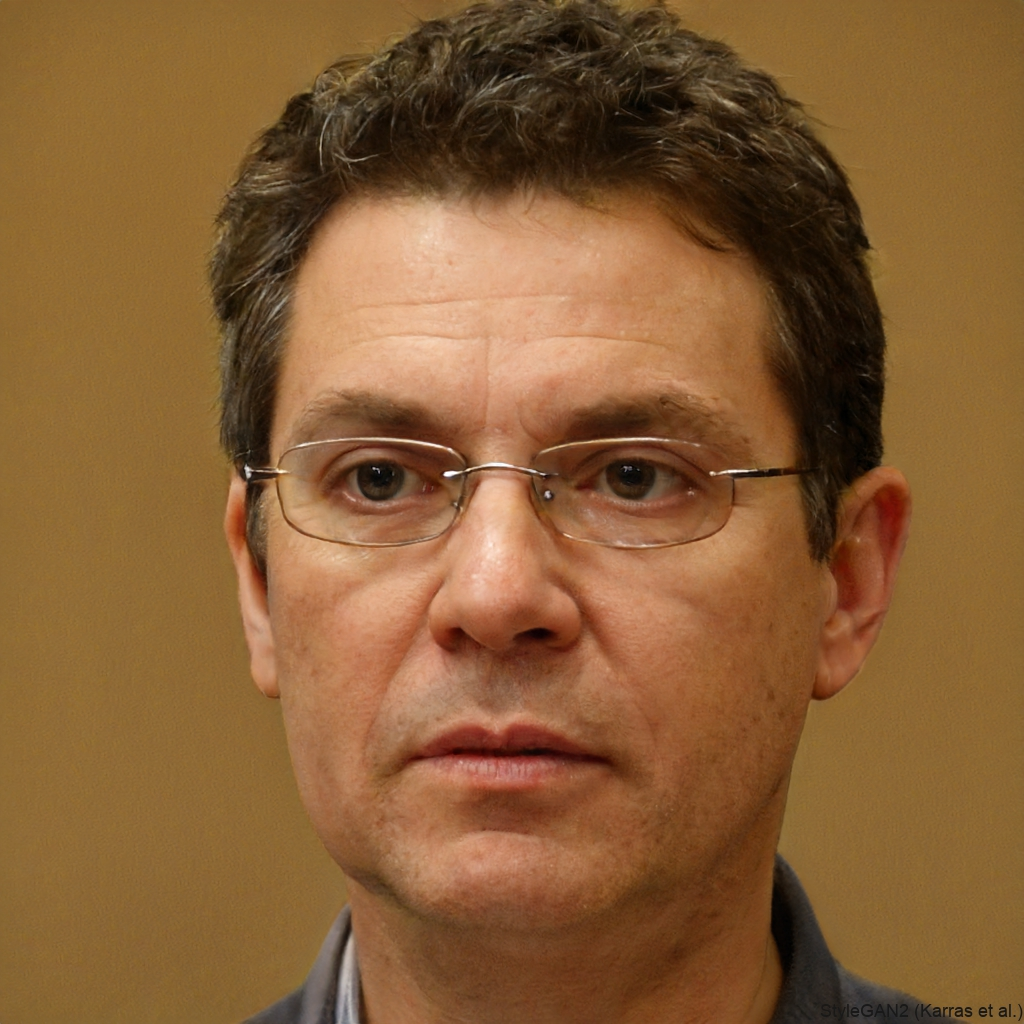

In [4]:

def img_file_path_to_img_bytes(file_path):
  with open(file_path, 'rb') as f:
    return f.read()


img_bytes = img_file_path_to_img_bytes('frontal1.jpg')
IPyImage(img_bytes)

In [5]:
from PIL import Image

def jpg_to_png(jpg_path, png_path):
  """Converts a JPG image to PNG format."""
  try:
    img = Image.open(jpg_path)
    img.save(png_path, 'PNG')
    print(f"Successfully converted {jpg_path} to {png_path}")
  except Exception as e:
    print(f"Error converting {jpg_path}: {e}")

# Example usage:
jpg_file = '/content/frontal1.jpg'
png_file = '/content/frontal1.png'
jpg_to_png(jpg_file, png_file)

Successfully converted /content/frontal1.jpg to /content/frontal1.png


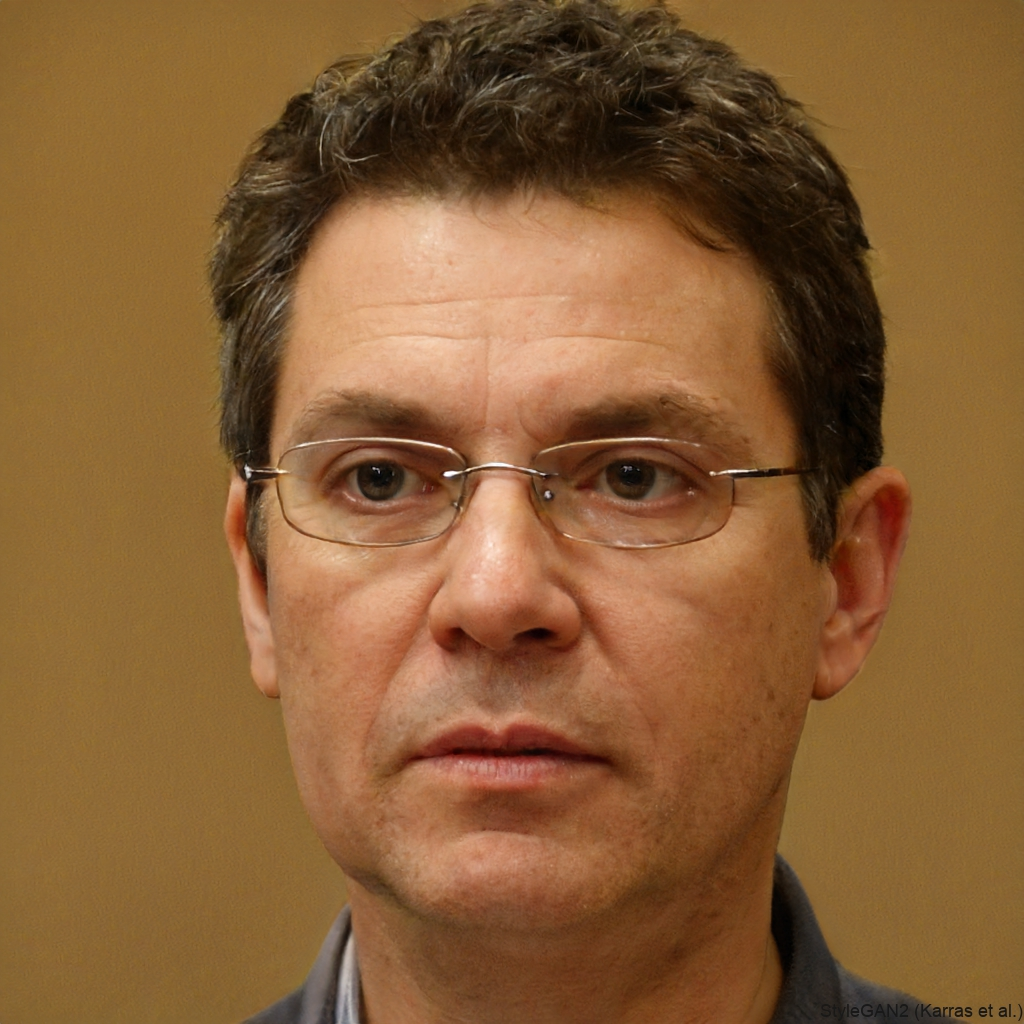

In [6]:
img_bytes = img_file_path_to_img_bytes('frontal1.png')
IPyImage(img_bytes)

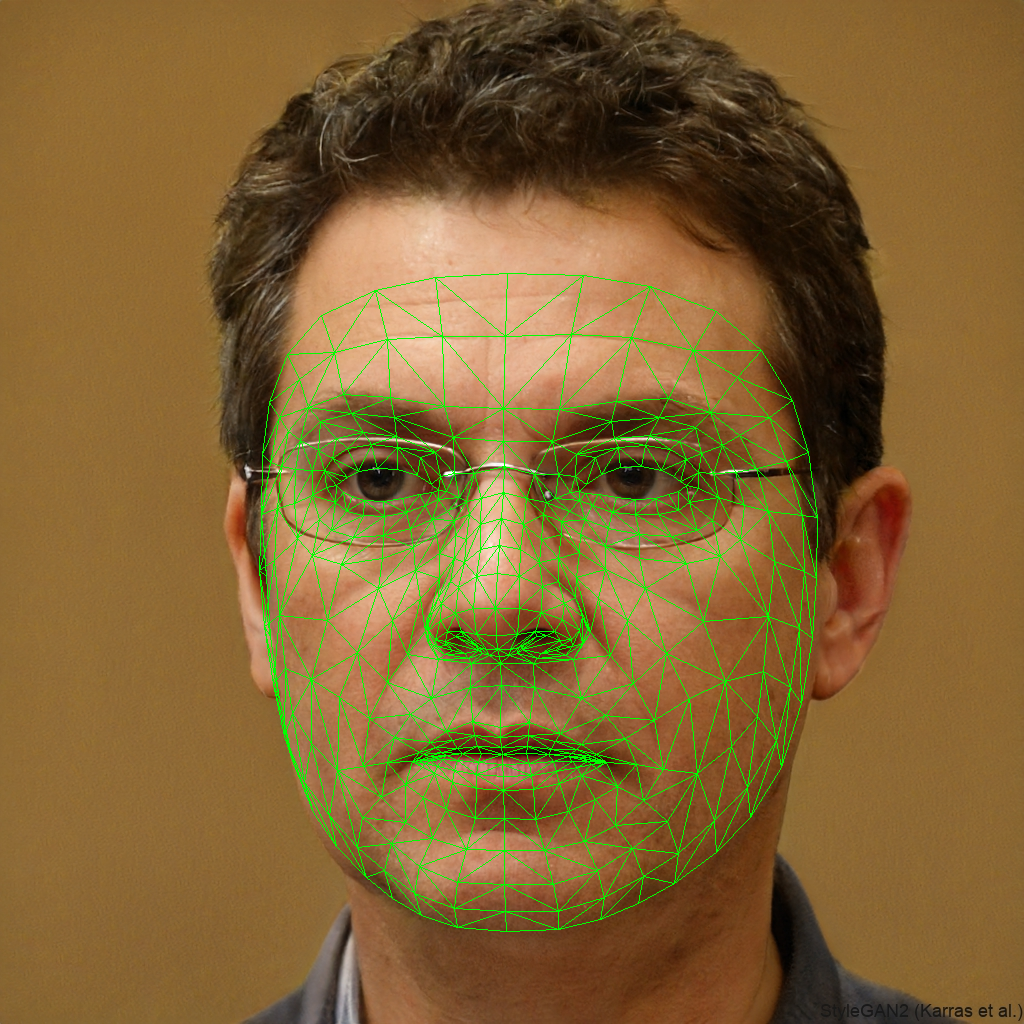

In [7]:
def img_bytes_to_meshed_img_bytes(img_bytes):
    # Decode image from raw bytes
    img_array = np.frombuffer(img_bytes, dtype=np.uint8)
    image = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)

    if image is None:
        raise ValueError("Could not decode image from bytes")

    # Handle alpha channel or grayscale
    if image.ndim == 3 and image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    elif image.ndim == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Convert BGR → RGB
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Run MediaPipe Face Mesh
    mp_face_mesh = mp.solutions.face_mesh
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
        results = face_mesh.process(img_rgb)

    # Copy for drawing
    output_img_rgb = img_rgb.copy()
    if results.multi_face_landmarks:
        mp_drawing = mp.solutions.drawing_utils
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=output_img_rgb,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing.DrawingSpec(
                    color=(0, 255, 0), thickness=1, circle_radius=0)
            )

    # Convert result back to PNG bytes
    img_pil = Image.fromarray(output_img_rgb)
    buf = BytesIO()
    img_pil.save(buf, format="PNG")
    buf.seek(0)
    return buf.getvalue()

# Example usage
img_mesh_bytes = img_bytes_to_meshed_img_bytes(img_bytes)
IPyImage(img_mesh_bytes)  # display in notebook


In [8]:
from math import dist
import json
def png_bytes_to_morphometric_json(png_bytes):
    # Decode image from bytes
    png_array = np.frombuffer(png_bytes, dtype=np.uint8)
    image = cv2.imdecode(png_array, cv2.IMREAD_UNCHANGED)

    if image.shape[-1] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    elif len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize Mediapipe FaceMesh
    mp_face_mesh = mp.solutions.face_mesh
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True
    ) as face_mesh:

        results = face_mesh.process(img_rgb)

    if not results.multi_face_landmarks:
        return json.dumps({"error": "No face detected"})

    # Get image dimensions
    h, w, _ = img_rgb.shape
    face_landmarks = results.multi_face_landmarks[0]

    # Convert normalized landmarks to pixel coordinates
    landmarks = [(int(lm.x * w), int(lm.y * h)) for lm in face_landmarks.landmark]

    # Example morphometric measurements
    # Define some standard landmarks based on Mediapipe indices
    measurements = {}

    def euclidean(p1, p2):
        return dist(landmarks[p1], landmarks[p2])

    # Sample morphometrics
    measurements["interocular_distance"] = euclidean(33, 263)  # Eye corners
    measurements["eye_width_left"] = euclidean(133, 33)
    measurements["eye_width_right"] = euclidean(362, 263)
    measurements["nose_width"] = euclidean(97, 326)
    measurements["nose_length"] = euclidean(1, 2)
    measurements["mouth_width"] = euclidean(61, 291)
    measurements["face_width"] = euclidean(234, 454)
    measurements["face_height"] = euclidean(10, 152)

    # You can normalize or return raw pixels depending on your use case
    return json.dumps(measurements)


png_bytes_to_morphometric_json(img_bytes)

'{"interocular_distance": 350.0, "eye_width_left": 102.12247548899312, "eye_width_right": 107.16809226630845, "nose_width": 62.0, "nose_length": 28.284271247461902, "mouth_width": 194.0025773024678, "face_width": 550.0036363516155, "face_height": 658.0007598779807}'

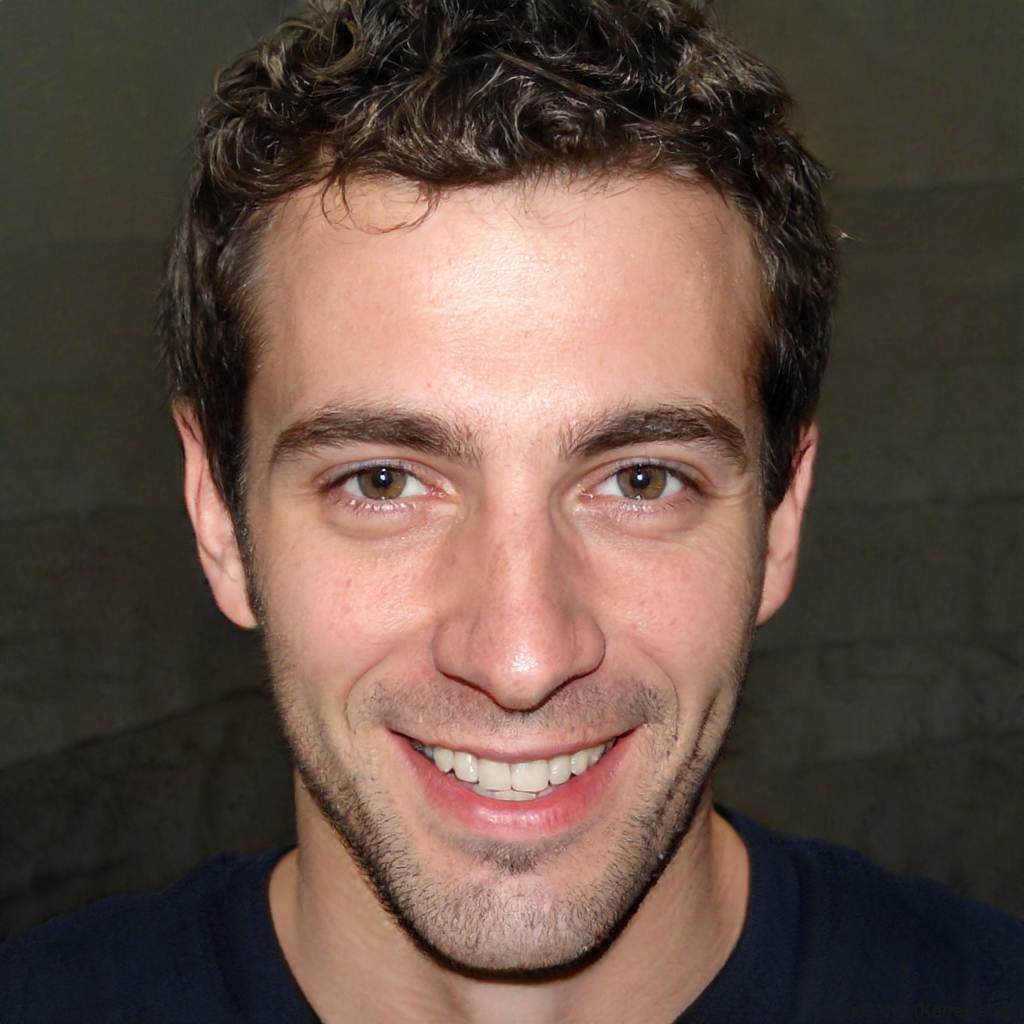

In [9]:
import requests
import random

def get_random_face_bytes():
    """
    Downloads a random face from thispersondoesnotexist.com
    and returns it as raw image bytes.
    """
    url = "https://thispersondoesnotexist.com/"
    resp = requests.get(url)
    if resp.status_code != 200:
        raise RuntimeError(f"Failed to download image, status code: {resp.status_code}")
    return resp.content

# Example usage
img_bytes = get_random_face_bytes()

# Display in notebook
from IPython.display import Image as IPyImage
IPyImage(img_bytes)


In [10]:
import json

io_distances = []

for i in range(100):
    try:
        img_bytes = get_random_face_bytes()
        morpho_json = png_bytes_to_morphometric_json(img_bytes)
        morpho = json.loads(morpho_json)  # <-- parse JSON

        if "interocular_distance" in morpho:
            io_distances.append(morpho["interocular_distance"])
    except Exception as e:
        print(f"Skipping face {i} due to error: {e}")


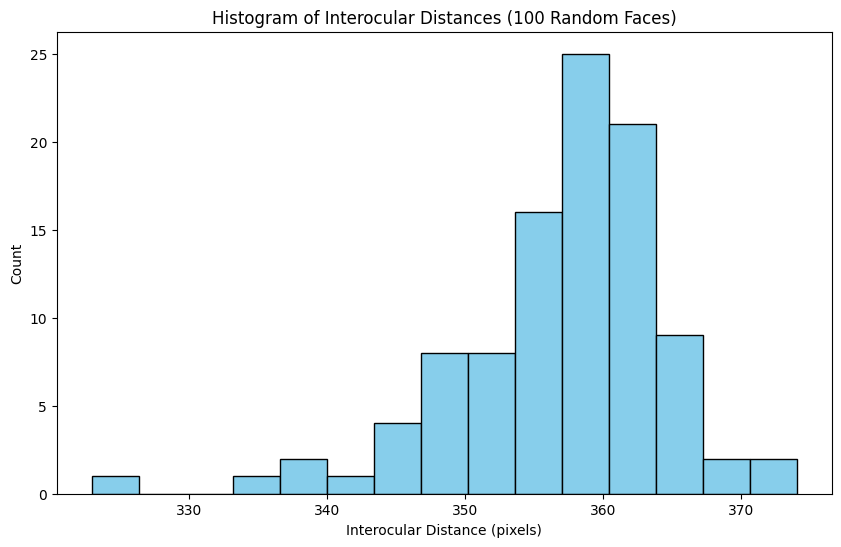

In [11]:
import matplotlib.pyplot as plt
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(io_distances, bins=15, color='skyblue', edgecolor='black')
plt.title("Histogram of Interocular Distances (100 Random Faces)")
plt.xlabel("Interocular Distance (pixels)")
plt.ylabel("Count")
plt.show()

In [12]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=io_distances,
    nbinsx=15,
    marker_color='skyblue',
    marker_line_color='black',
    marker_line_width=1
))

fig.update_layout(
    title="Histogram of Interocular Distances (100 Random Faces)",
    xaxis_title="Interocular Distance (pixels)",
    yaxis_title="Count",
    bargap=0.1,
    template="plotly_white"
)

fig.show()
